In [1]:
import numpy as np
from matplotlib import pyplot as plt

%matplotlib inline

## Tight-Binding, Silicon

#### Ref: J. Chadi and M. Cohen, phys. stat. sol. (b) 68, 405 (1975)

Tight binding Hamiltonian for Si:

$$
\left(
\begin{array}{cccccccc}
E_s & V_{ss} g_0 & 0 & 0 & 0 & V_{s0p} g_1 & V_{s0p} g_2 & V_{s0p} g_3 \\
V_{ss} g_0^* & E_s & -V_{s1p} g_1^* & V_{s1p} g_2^* & -V_{s1p} g_3^* & 0 & 0 & 0 \\
0 & -V_{s1p} g_1 & E_{p0} & 0 & 0 & V_{xx} g_0 & V_{xy} g_3 & V_{xy} g_2 \\
0 & -V_{s1p} g_2 & 0 & E_{p0} & 0 & V_{xy} g_3 & V_{xx} g_0 & V_{xy} g_1 \\
0 & -V_{s1p} g_3 & 0 & 0 & E_{p0} & V_{xy} g_2 & V_{xy} g_1 & V_{xx} g_0 \\
V_{s0p} g_1^* & 0 & V_{xx} g_0^* & V_{xy} g_3^* & V_{xy} g_2^* & E_{p1} & 0 & 0 \\
V_{s0p} g_2^* & 0 & V_{xy} g_3^* & V_{xx} g_0^* & V_{xy} g_1^* & 0 & E_{p1} & 0 \\
V_{s0p} g_3^* & 0 & V_{xy} g_2^* & V_{xy} g_1^* & V_{xx} g_0^* & 0 & 0 & E_{p1}
\end{array}
\right)
$$

where:

$$
g_1(\vec{k}) = (\frac{1}{4})(e^{\mathrm{i} \vec{k} \cdot \vec{d_1}} + e^{\mathrm{i} \vec{k} \cdot \vec{d_2}} + e^{\mathrm{i} \vec{k} \cdot \vec{d_3}} + e^{\mathrm{i} \vec{k} \cdot \vec{d_4}} ) \\
g_2(\vec{k}) = (\frac{1}{4})(e^{\mathrm{i} \vec{k} \cdot \vec{d_1}} + e^{\mathrm{i} \vec{k} \cdot \vec{d_2}} - e^{\mathrm{i} \vec{k} \cdot \vec{d_3}} - e^{\mathrm{i} \vec{k} \cdot \vec{d_4}} ) \\
g_3(\vec{k}) = (\frac{1}{4})(e^{\mathrm{i} \vec{k} \cdot \vec{d_1}} - e^{\mathrm{i} \vec{k} \cdot \vec{d_2}} + e^{\mathrm{i} \vec{k} \cdot \vec{d_3}} - e^{\mathrm{i} \vec{k} \cdot \vec{d_4}}) \\
g_4(\vec{k}) =  (\frac{1}{4})(e^{\mathrm{i} \vec{k} \cdot \vec{d_1}} - e^{\mathrm{i} \vec{k} \cdot \vec{d_2}} - e^{\mathrm{i} \vec{k} \cdot \vec{d_3}} + e^{\mathrm{i} \vec{k} \cdot \vec{d_4}})
$$


In [2]:
def g(k, d):
    '''
    k : array shape (3,) - phase factor
    d: array shape (4, 3) - 4 nearest neighbours from atom at (0,0,0)
    
    '''
    #1j is complex number i
    #@ is matrix multiplication
    
    exp1, exp2, exp3, exp4 = [np.exp(1j * k @ rows) for rows in d]

    return (1/4)*np.array([ exp1 + exp2 + exp3 + exp4,
                            exp1 + exp2 - exp3 - exp4,
                            exp1 - exp2 + exp3 - exp4,
                            exp1 - exp2 - exp3 + exp4 ])

For diamond structure crystals $E_{p0} = E_{p1}$ and $V_{s0p} = V_{s1p}$ (Cohen)

In [3]:
def tb_eigenvals(g_i, E_s, E_p, V_ss, V_sp, V_xx, V_xy):
    '''
    g_i: array shape (4,)
    E_s, E_p, V_ss, V_sp, V_xx, V_xy: integers
                                    
    returns: array shape (8,) of tight binding eigenvalues
    '''
    
    cg_i = np.conjugate(g_i)

    tb_hamiltonian = np.array([
      [E_s, V_ss * g_i[0], 0, 0, 0, V_sp * g_i[1], V_sp * g_i[2], V_sp * g_i[3]],
      [V_ss * cg_i[0], E_s, -V_sp * cg_i[1], -V_sp * cg_i[2], -V_sp * cg_i[3], 0, 0, 0],
      [0, -V_sp * g_i[1], E_p, 0, 0, V_xx * g_i[0], V_xy * g_i[3], V_xy * g_i[2]],
      [0, -V_sp * g_i[2], 0, E_p, 0, V_xy * g_i[3], V_xx * g_i[0], V_xy * g_i[1]],
      [0, -V_sp * g_i[3], 0, 0, E_p, V_xy * g_i[2], V_xy * g_i[1], V_xx * g_i[0]],
      [V_sp * cg_i[1], 0, V_xx * cg_i[0], V_xy * cg_i[3], V_xy * cg_i[2], E_p, 0, 0],
      [V_sp * cg_i[2], 0, V_xy * cg_i[3], V_xx * cg_i[0], V_xy * cg_i[1], 0, E_p, 0],
      [V_sp * cg_i[3], 0, V_xy * cg_i[2], V_xy * cg_i[1], V_xx * cg_i[0], 0, 0, E_p] ])

    eigvals = np.linalg.eigvalsh(tb_hamiltonian)
    eigvals.sort()
    
    return eigvals


def bands_kpath(params, d, path):
    '''
    params: array shape (6,) - interaction parameters (eV)
    d: array shape (4, 3) - 4 nearest neighbours from atom at (0,0,0)
    path: array shape (n,) - n k-points in 1st Brillouin zone to calculate band structure over
    
    '''
    bands = []
    
    for k in np.vstack(path):
        g_i = g(k, d)
        eigvals = tb_eigenvals(g_i, *params)
        bands.append(eigvals)
        
    return np.stack(bands, axis=-1)

In [4]:
# E_s, E_p, V_ss, V_sp, V_xx, V_xy (Cohen)
params = (0, 7.20, -8.13, 5.88, 3.17, 7.51)

# lattice constant
a = 5.4e-10

# nearest neighbours
d = (a/4)*np.array([ [1, 1, 1],
                     [1, -1, -1],
                     [-1, 1, -1],
                     [-1, -1, 1] ])

# Brillouin points
G = 2 * np.pi / a * np.array([0, 0, 0])
L = 2 * np.pi / a * np.array([1/2, 1/2, 1/2])
X = 2 * np.pi / a * np.array([0, 0, 1])

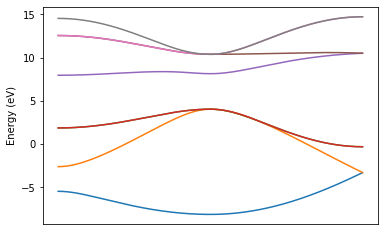

In [5]:
# plot energy eigenvalues for n points across k-path

def kpoints(x,y,n=1000, endpoint=True):
    spacings = [np.linspace(start, end, num=n, endpoint=endpoint) for start, end in zip(x,y)]
    return np.stack(spacings, axis=-1)

lambd = kpoints(L, G, endpoint=False)
delta = kpoints(G, X, endpoint=False)

bands = bands_kpath(params, d, path=[lambd, delta])

plt.figure()
plt.ylabel('Energy (eV)')
plt.xticks([])
for band in bands:
    plt.plot(band)
plt.show()

In [6]:
# find minimum energy in conduction band (row 4 of the band structure matrix)

min_e = np.min(bands[4])
k_point = np.where(bands[4] == np.min(bands[4]))
 
print('minimum energy in conduction band :', min_e, 'eV')
print('index of minimum element :', k_point[0])

minimum energy in conduction band : 7.949850850166131 eV
index of minimum element : [0]


Therefore this minimum here is at the L point: $k = \frac{2\pi}{a} (\frac{1}{2}, \frac{1}{2}, \frac{1}{2})$ ($L-\Gamma$ path)

If we consider the $\Gamma-X$ path, there is a minimum at the $\Gamma$ point, $k = (0,0,0)$:

In [7]:
min_e_G = bands[4,1000] #n = 1000th point is gamma point
print('minimum energy in conduction band (Γ-X path):', min_e_G, 'eV')

minimum energy in conduction band (Γ-X path): 8.13 eV
